# Prototype
#### Import necessary packages:

In [1]:
import seaborn as sns
import pandas as pd

from sklearn.dummy import DummyRegressor
from sklearn.ensemble import RandomForestRegressor

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

In /Users/cathleenpena1/anaconda3/lib/python3.8/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The text.latex.preview rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In /Users/cathleenpena1/anaconda3/lib/python3.8/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The mathtext.fallback_to_cm rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In /Users/cathleenpena1/anaconda3/lib/python3.8/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: Support for setting the 'mathtext.fallback_to_cm' rcParam is deprecated since 3.3 and will be removed two minor releases later; use 'mathtext.fallback : 'cm' instead.
In /Users/cathleenpena1/anaconda3/lib/python3.8/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The validate_bool_maybe_none function was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In /Users/cathleenpena1/anac

### Load Data

In [19]:
df = pd.read_csv('data/argentina_final.csv')
df.drop('Unnamed: 0', axis=1, inplace=True)
df.head(3)

,start_date,end_date,created_on,lat,lon,rooms,bedrooms,bathrooms,surface_total,surface_covered,...,property_type_House,property_type_Lot,property_type_Office,property_type_Other,property_type_PH,property_type_Shop,property_type_Warehouse,operation_type_For Rent,operation_type_For Sale,operation_type_For Sublease
0,2020-06-17,2020-06-18,2020-06-17,-34.995340,-58.047423,2.844661,0.0,1.70148,474.884308,6370.15545,...,0,0,0,0,0,0,0,0,1,0
1,2020-05-20,2020-05-20,2020-05-20,-34.816634,-59.193616,5.000000,2.0,1.00000,72.000000,72.00000,...,0,0,0,0,0,0,0,0,1,0
2,2020-07-14,2020-08-13,2020-07-14,-31.116769,-64.482921,2.844661,3.0,1.00000,747.000000,244.00000,...,1,0,0,0,0,0,0,0,1,0


In [3]:
df['start_date']= pd.to_datetime(df['start_date'])
df['end_date']= pd.to_datetime(df['end_date'])
df['created_on']= pd.to_datetime(df['created_on'])

### Split data

In [4]:
X_train, X_test, y_train, y_test = train_test_split(df.drop(['price', 'start_date', 'end_date', 'created_on'], axis=1), df.price, test_size=.3)
print(len(X_train)/len(df), "\n", len(X_test)/len(df))

0.6999993770104392 
 0.30000062298956076


## Create Model

In [5]:
%%time
rfr = RandomForestRegressor(n_jobs=-1)

rfr.fit(X_train, y_train)
rfr_preds = rfr.predict(X_test)

CPU times: user 31min 49s, sys: 28.9 s, total: 32min 18s
Wall time: 12min 8s


In [6]:
rfr.get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'criterion': 'mse',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': -1,
 'oob_score': False,
 'random_state': None,
 'verbose': 0,
 'warm_start': False}

## Evaluate Model 

In [7]:
rfr_rmse = mean_squared_error(y_test, rfr_preds, squared=False)

print("RMSE - Random Forest: ", rfr_rmse)

RMSE - Random Forest:  13293263.756443547


#### K-fold cross validation

In [10]:
%%time 
all_accuracies = cross_val_score(estimator=rfr, X=X_train, y=y_train, cv=5, scoring="neg_root_mean_squared_error")

CPU times: user 1min 39s, sys: 1min 19s, total: 2min 59s
Wall time: 36min 45s


In [11]:
all_accuracies

array([  -285023.16344484, -18523289.20601667, -27234359.65737875,
        -1197589.52562492,  -7088708.15690203])

## Hyperparameter Tuning
Grid Search CV

In [12]:
param_grid = {
    'max_depth': [None, 80],
    'min_samples_leaf': [1, 3, 5],
    'n_estimators': [100, 500, 800]
}

In [13]:
%%time
grid_search = GridSearchCV(estimator=rfr, param_grid=param_grid, cv=3, n_jobs=-1, verbose=2)
grid_search.fit(X_train, y_train)
grid_search.best_params_

Fitting 3 folds for each of 18 candidates, totalling 54 fits
CPU times: user 28min 57s, sys: 13.8 s, total: 29min 11s
Wall time: 23h 28min 18s


{'max_depth': None, 'min_samples_leaf': 5, 'n_estimators': 100}

In [14]:
%%time
best_grid = grid_search.best_estimator_
best_grid_preds = best_grid.predict(X_test)
best_grid_rmse = mean_squared_error(y_test, best_grid_preds, squared=False)

CPU times: user 19.5 s, sys: 405 ms, total: 19.9 s
Wall time: 6.4 s


In [15]:
print("Base RMSE: \t", rfr_rmse)
print("Tuned RMSE: \t", best_grid_rmse)

Base RMSE: 	 363768.8377066086
Tuned RMSE: 	 4871377.790158139


In [31]:
rfr.get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'criterion': 'mse',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': -1,
 'oob_score': False,
 'random_state': None,
 'verbose': 0,
 'warm_start': False}

In [30]:
best_grid.get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'criterion': 'mse',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 5,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': -1,
 'oob_score': False,
 'random_state': None,
 'verbose': 0,
 'warm_start': False}

# Compare to base model and untuned model
Metrics and Visualizations

In [16]:
dummy_mean = DummyRegressor(strategy = 'mean').fit(X_train, y_train)
mean_preds = dummy_mean.predict(X_test)

dme_rmse = mean_squared_error(y_test, mean_preds, squared=False)

In [18]:
evals = pd.DataFrame([['Base Model', dme_rmse], 
                      ['Untuned Randomn Forest', rfr_rmse], 
                      ['Tuned Random Forest', best_grid_rmse]], columns=['Model', 'RMSE'])

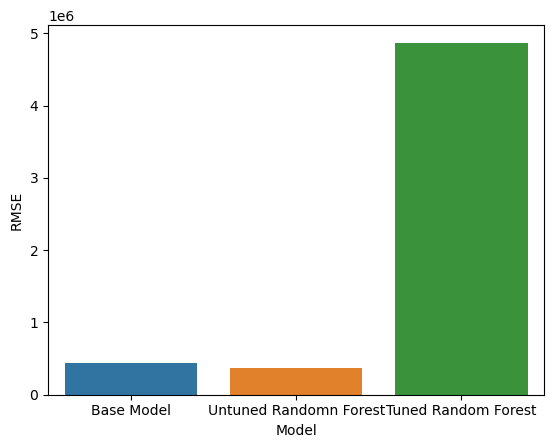

In [28]:
import matplotlib.pyplot as plt
sns.barplot(data=evals, x='Model', y='RMSE')
plt.show()

## Train model on whole dataset, then save

In [28]:
%%time

x = df.drop(['price', 'start_date', 'end_date', 'created_on'], axis=1)
y = df.price

rfr_final = RandomForestRegressor(n_jobs=-1)
rfr_final.fit(x, y)

CPU times: user 38min 45s, sys: 27.4 s, total: 39min 12s
Wall time: 14min 19s


RandomForestRegressor(n_jobs=-1)

In [29]:
import pickle
# save the model to disk
filename = 'models/rfr_model.pkl'
pickle.dump(rfr_final, open(filename, 'wb'))

### Save columns the model uses

In [24]:
model_cols = list(x.columns)
filename2 = 'models/rfr_model_columns.pkl'
pickle.dump(model_cols, open(filename2, 'wb'))

In [26]:
# load the model from disk
#loaded_model = pickle.load(open(filename, 'rb'))
#result_preds = rfr.predict(X_test)
#result_rmse = mean_squared_error(y_test, result_preds, squared=False)

In [27]:
#print(result_rmse)

In [14]:
#X_train.columns

Index(['lat', 'lon', 'rooms', 'bedrooms', 'bathrooms', 'surface_total',
       'surface_covered', 'l1_Argentina', 'l1_Brasil', 'l1_Estados Unidos',
       'l1_Uruguay', 'l2_Bs.As. G.B.A. Zona Norte',
       'l2_Bs.As. G.B.A. Zona Oeste', 'l2_Bs.As. G.B.A. Zona Sur',
       'l2_Buenos Aires Costa Atlántica', 'l2_Buenos Aires Interior',
       'l2_Canelones', 'l2_Capital Federal', 'l2_Catamarca', 'l2_Chaco',
       'l2_Chubut', 'l2_Colonia', 'l2_Corrientes', 'l2_Córdoba',
       'l2_Entre Ríos', 'l2_Florida', 'l2_Formosa', 'l2_Jujuy', 'l2_La Pampa',
       'l2_La Rioja', 'l2_Maldonado', 'l2_Maryland', 'l2_Mendoza', 'l2_Miami',
       'l2_Michigan', 'l2_Misiones', 'l2_Montevideo', 'l2_Neuquén',
       'l2_New York', 'l2_Pennsylvania', 'l2_Rio Grande do Norte',
       'l2_Rio de Janeiro', 'l2_Rocha', 'l2_Río Negro', 'l2_Salta',
       'l2_San Juan', 'l2_San Luis', 'l2_Santa Catarina', 'l2_Santa Cruz',
       'l2_Santa Fe', 'l2_Santiago Del Estero', 'l2_São Paulo',
       'l2_Tierra Del Fue

In [ ]:
['lat', 'lon', 'rooms', 'bedrooms', 'bathrooms', 'surface_total',
       'surface_covered', 'l1_Argentina', 'l1_Brasil', 'l1_Estados Unidos',
       'l1_Uruguay', 'l2_Bs.As. G.B.A. Zona Norte',
       'l2_Bs.As. G.B.A. Zona Oeste', 'l2_Bs.As. G.B.A. Zona Sur',
       'l2_Buenos Aires Costa Atlántica', 'l2_Buenos Aires Interior',
       'l2_Canelones', 'l2_Capital Federal', 'l2_Catamarca', 'l2_Chaco',
       'l2_Chubut', 'l2_Colonia', 'l2_Corrientes', 'l2_Córdoba',
       'l2_Entre Ríos', 'l2_Florida', 'l2_Formosa', 'l2_Jujuy', 'l2_La Pampa',
       'l2_La Rioja', 'l2_Maldonado', 'l2_Maryland', 'l2_Mendoza', 'l2_Miami',
       'l2_Michigan', 'l2_Misiones', 'l2_Montevideo', 'l2_Neuquén',
       'l2_New York', 'l2_Pennsylvania', 'l2_Rio Grande do Norte',
       'l2_Rio de Janeiro', 'l2_Rocha', 'l2_Río Negro', 'l2_Salta',
       'l2_San Juan', 'l2_San Luis', 'l2_Santa Catarina', 'l2_Santa Cruz',
       'l2_Santa Fe', 'l2_Santiago Del Estero', 'l2_São Paulo',
       'l2_Tierra Del Fuego', 'l2_Tucumán', 'property_type_Cottage',
       'property_type_Department', 'property_type_Garage',
       'property_type_House', 'property_type_Lot', 'property_type_Office',
       'property_type_Other', 'property_type_PH', 'property_type_Shop',
       'property_type_Warehouse', 'operation_type_For Rent',
       'operation_type_For Sale', 'operation_type_For Sublease']